In [1]:
from metabolinks import align, read_aligned_spectra, read_spectra_from_xcel
from metabolinks.similarity import mz_similarity

### Similarity analysis without CHT, CFN and SB samples.

All further changes to code will first be implemented on the original similarity_analysis. This is an altered version of said original.

Coloured labels in dendrograms that have the 39 samples.

## Similarity analysis

#### Read aligned data, using peaks that appear in at least 2 samples

In [2]:
from metabolinks import AlignedSpectra
aligned_all_pos_f = read_aligned_spectra('aligned_1ppm_min2_1ppm_positive.csv', labels=True, sep=',')
aligned_all_neg_f = read_aligned_spectra('aligned_1ppm_min2_1ppm_negative.csv', labels=True, sep=',')

de_neg = aligned_all_neg_f.data
de_neg = de_neg[["14","15","16","29","30","31","8","9","10","23","24","25","38","39","40","17","18","19","26","27","28","20","21","22","35","36","37","32","33","34"]]
aligned_all_neg = AlignedSpectra(de_neg, labels=["CAN","CAN","CAN","CS","CS","CS","LAB","LAB","LAB","PN","PN","PN","REG","REG","REG","RIP","RIP","RIP","RL","RL","RL","ROT","ROT","ROT","RU","RU","RU","TRI","TRI","TRI"])

de_pos = aligned_all_pos_f.data
de_pos = de_pos[["14","15","16","29","30","31","8","9","10","23","24","25","38","39","40","17","18","19","26","27","28","20","21","22","35","36","37","32","33","34"]]
aligned_all_pos = AlignedSpectra(de_pos, labels=["CAN","CAN","CAN","CS","CS","CS","LAB","LAB","LAB","PN","PN","PN","REG","REG","REG","RIP","RIP","RIP","RL","RL","RL","ROT","ROT","ROT","RU","RU","RU","TRI","TRI","TRI"])

#print('------ positive mode aligned --------------')
#print(aligned_all_pos.info())
#print('------ negative mode aligned --------------')
#print(aligned_all_neg.info())

#### Compute m/z similarities

In [3]:
sim_pos = mz_similarity(aligned_all_pos)
sim_neg = mz_similarity(aligned_all_neg)

In [4]:
print(sim_pos)


Sample similarity, counts of common peaks
     14   15   16   29   30   31    8    9   10    23  ...   28   20   21  \
14  330  277  253  202  200  195  207  214  207   152  ...  211  133  132   
15  277  379  302  233  232  224  227  231  223   179  ...  239  146  143   
16  253  302  355  222  222  218  212  212  208   164  ...  229  148  146   
29  202  233  222  667  514  526  230  233  235   308  ...  388  162  148   
30  200  232  222  514  612  471  236  236  235   284  ...  376  162  149   
31  195  224  218  526  471  624  232  237  239   294  ...  367  166  150   
8   207  227  212  230  236  232  489  399  369   182  ...  233  148  152   
9   214  231  212  233  236  237  399  501  381   184  ...  241  147  147   
10  207  223  208  235  235  239  369  381  471   181  ...  244  152  155   
23  152  179  164  308  284  294  182  184  181  1487  ...  334  127  118   
24  151  176  162  308  286  297  187  190  188  1246  ...  330  125  117   
25  146  174  159  296  269  286 

In [5]:
print(sim_neg)


Sample similarity, counts of common peaks
     14   15   16   29   30   31    8    9   10   23  ...   28   20   21   22  \
14  442  286  345  186  183  170  168  179  179   34  ...  104  156  141  146   
15  286  319  222  121  118  108  144  157  155   25  ...   86  134  121  125   
16  345  222  378  174  171  159  168  181  177   34  ...   95  108  100  109   
29  186  121  174  674  637  588  143  151  150   88  ...  416  106   97  106   
30  183  118  171  637  677  591  142  150  149   88  ...  416  108   99  108   
31  170  108  159  588  591  628  128  135  135   87  ...  409  103   95  103   
8   168  144  168  143  142  128  370  331  339  118  ...  168  111  107  115   
9   179  157  181  151  150  135  331  402  371  111  ...  163  121  115  123   
10  179  155  177  150  149  135  339  371  410  120  ...  171  114  110  118   
23   34   25   34   88   88   87  118  111  120  350  ...  150   36   39   39   
24   46   33   45   95   95   94  127  121  129  314  ...  156   4

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import seaborn as sns
import pandas as pd

In [7]:
dfpos = pd.DataFrame(sim_pos.sample_similarity_jaccard,
                     columns=sim_pos.sample_names,
                     index=sim_pos.sample_names)

dfneg = pd.DataFrame(sim_neg.sample_similarity_jaccard,
                     columns=sim_neg.sample_names,
                     index=sim_neg.sample_names)

Sample similarity, positive mode


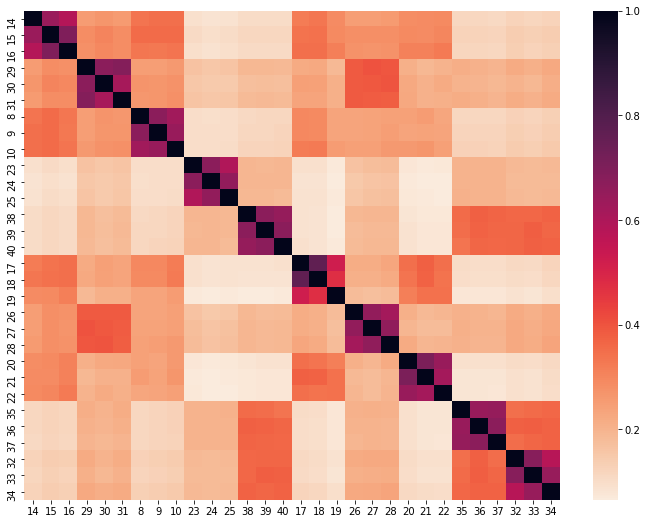

In [8]:
f, ax = plt.subplots(figsize=(12, 9))

print('Sample similarity, positive mode')
hm = sns.heatmap(dfpos, annot=False, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Sample similarity, negative mode


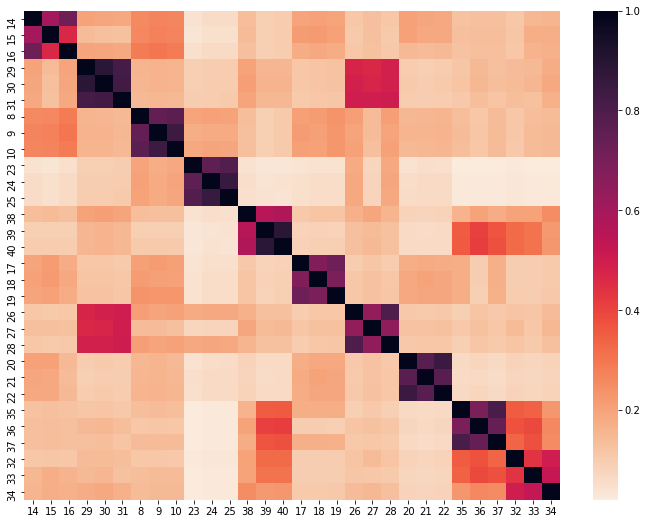

In [9]:
f, ax = plt.subplots(figsize=(12, 9))

print('Sample similarity, negative mode')
hm = sns.heatmap(dfneg, annot=False, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [10]:
dfpos = pd.DataFrame(sim_pos.label_similarity_jaccard,
                     columns=sim_pos.unique_labels,
                     index=sim_pos.unique_labels)

dfneg = pd.DataFrame(sim_neg.label_similarity_jaccard,
                     columns=sim_neg.unique_labels,
                     index=sim_neg.unique_labels)

Label similarity, positive mode


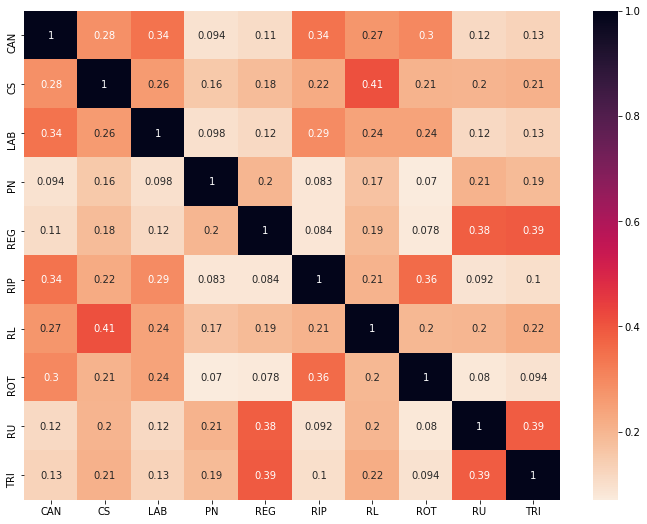

In [11]:
f, ax = plt.subplots(figsize=(12, 9))

print('Label similarity, positive mode')
hm = sns.heatmap(dfpos, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Label similarity, negative mode


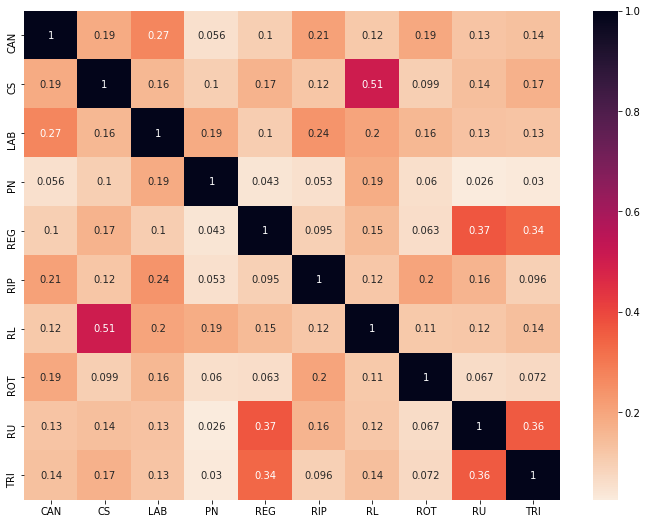

In [12]:
f, ax = plt.subplots(figsize=(12, 9))

print('Label similarity, negative mode')
hm = sns.heatmap(dfneg, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

#### Doing... Experiments with scipy functions...

In [13]:
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier

In [14]:
def df_to_bool(df):
    df = df.copy()
    df[df.notnull()] = 1
    df[df.isnull()] = 0
    return df
aligned_01 = df_to_bool(aligned_all_neg.data)
# confirm it is 0's and 1's
#aligned_01

In [15]:
jdist = dist.pdist(aligned_01.T, metric='jaccard')
print(dist.squareform(jdist))
print('------------------------------------')
sim = mz_similarity(aligned_all_neg)
jsim = sim.sample_similarity_jaccard
jdist = 1 - jsim
print(jdist)

[[0.         0.39789474 0.27368421 0.8        0.80448718 0.81111111
  0.73913043 0.73082707 0.73402675 0.95514512 0.94041451 0.94132653
  0.86278814 0.90507365 0.89764419 0.80106101 0.79511533 0.80289093
  0.88624052 0.86568987 0.88817204 0.79337748 0.80763984 0.80915033
  0.87579329 0.86910491 0.86825818 0.88685345 0.84623773 0.84205021]
 [0.39789474 0.         0.53263158 0.86123853 0.86560364 0.87127533
  0.73577982 0.72163121 0.72996516 0.96118012 0.95015106 0.95103858
  0.85588972 0.90441839 0.89624329 0.7834891  0.77990431 0.79510703
  0.89364303 0.86797753 0.89575758 0.79510703 0.80793651 0.81146305
  0.86828774 0.86515642 0.86457311 0.88206388 0.82537688 0.82577566]
 [0.27368421 0.53263158 0.         0.80182232 0.80656109 0.81227863
  0.71034483 0.69782972 0.71031097 0.95100865 0.93653032 0.93758669
  0.86581097 0.90737564 0.89957447 0.82187938 0.81438849 0.82033426
  0.88554913 0.86928105 0.89142857 0.85385656 0.85915493 0.85230352
  0.87464115 0.86863544 0.86778399 0.8862069  

[[0.         0.39789474 0.27368421 0.8        0.80448718 0.81111111
  0.73913043 0.73082707 0.73402675 0.95514512 0.94041451 0.94132653
  0.86278814 0.90507365 0.89764419 0.80106101 0.79511533 0.80289093
  0.88624052 0.86568987 0.88817204 0.79337748 0.80763984 0.80915033
  0.87579329 0.86910491 0.86825818 0.88685345 0.84623773 0.84205021]
 [0.39789474 0.         0.53263158 0.86123853 0.86560364 0.87127533
  0.73577982 0.72163121 0.72996516 0.96118012 0.95015106 0.95103858
  0.85588972 0.90441839 0.89624329 0.7834891  0.77990431 0.79510703
  0.89364303 0.86797753 0.89575758 0.79510703 0.80793651 0.81146305
  0.86828774 0.86515642 0.86457311 0.88206388 0.82537688 0.82577566]
 [0.27368421 0.53263158 0.         0.80182232 0.80656109 0.81227863
  0.71034483 0.69782972 0.71031097 0.95100865 0.93653032 0.93758669
  0.86581097 0.90737564 0.89957447 0.82187938 0.81438849 0.82033426
  0.88554913 0.86928105 0.89142857 0.85385656 0.85915493 0.85230352
  0.87464115 0.86863544 0.86778399 0.8862069  

## Wrapping up in a function...

In [16]:
def clustermap_peak_list(aligned):
    aligned_01 = aligned.data.copy()
    aligned_01[aligned_01.notnull()] = 1
    aligned_01[aligned_01.isnull()] = 0
    
    ulabels = aligned.unique_labels()
    n = len(ulabels)
    
    p = sns.color_palette() + sns.color_palette("Set1", n_colors=n-10, desat=.5)
    sample_to_labels = pd.Series(aligned.labels, index=aligned.sample_names)
    label_colors = pd.Series(p, index=ulabels)
    sample_colors = sample_to_labels.map(label_colors)
    
    g = sns.clustermap(aligned_01, metric="jaccard", figsize=(15, 20), 
                       row_cluster=False,
                       col_colors=sample_colors,
                       yticklabels=False)
    # fix bug in seaborn, error in clustermap if cbar == False
    ax=g.cax; aax=ax.clear(); aax = ax.axis('off'); 

    # draw legend
    lpatches = [mpatches.Patch(color=c, label=lbl) for (lbl, c) in label_colors.iteritems()]
    leg = plt.legend(handles=lpatches, fontsize=20)
    return g
    

Sample HC, NEGATIVE mode


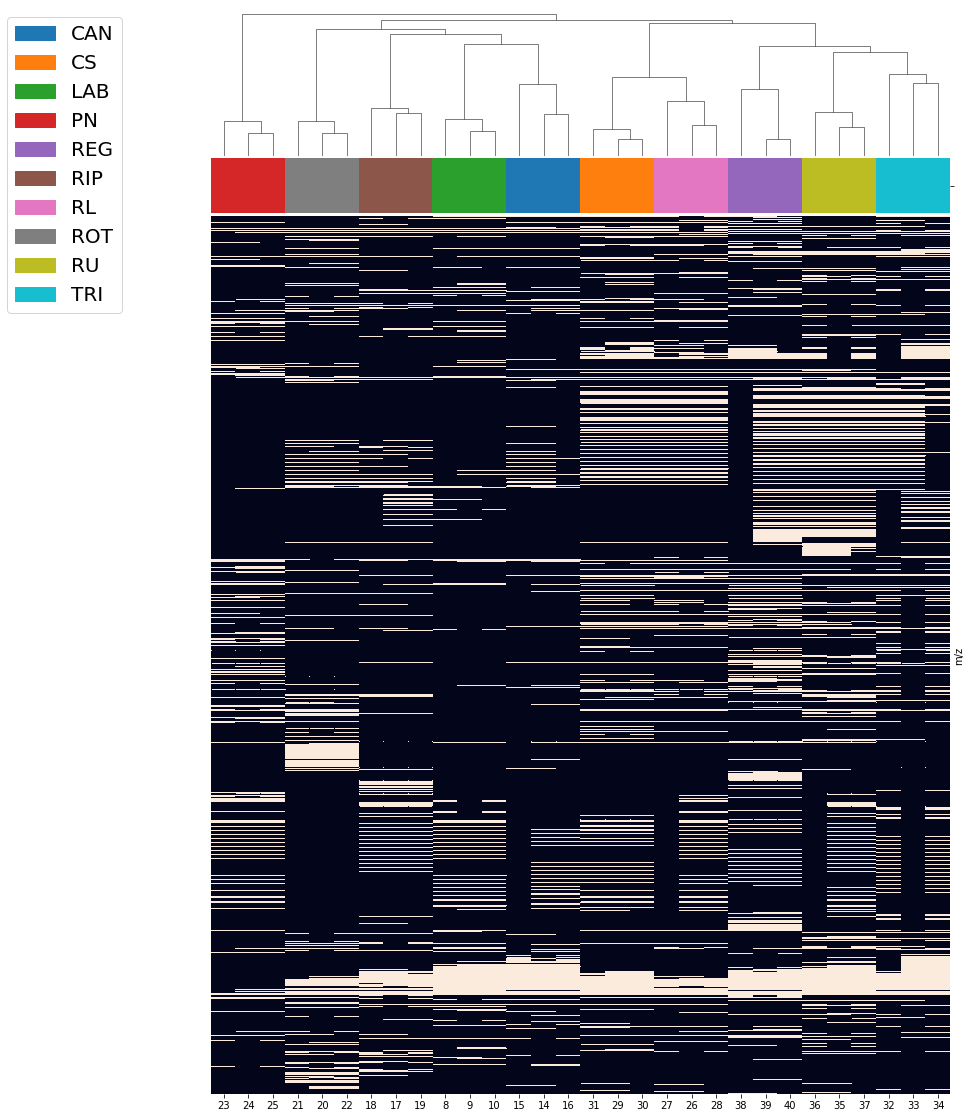

In [17]:
print('Sample HC, NEGATIVE mode')
g = clustermap_peak_list(aligned_all_neg)
g.savefig('sampleHC_negative.pdf')


Sample HC, POSITIVE mode


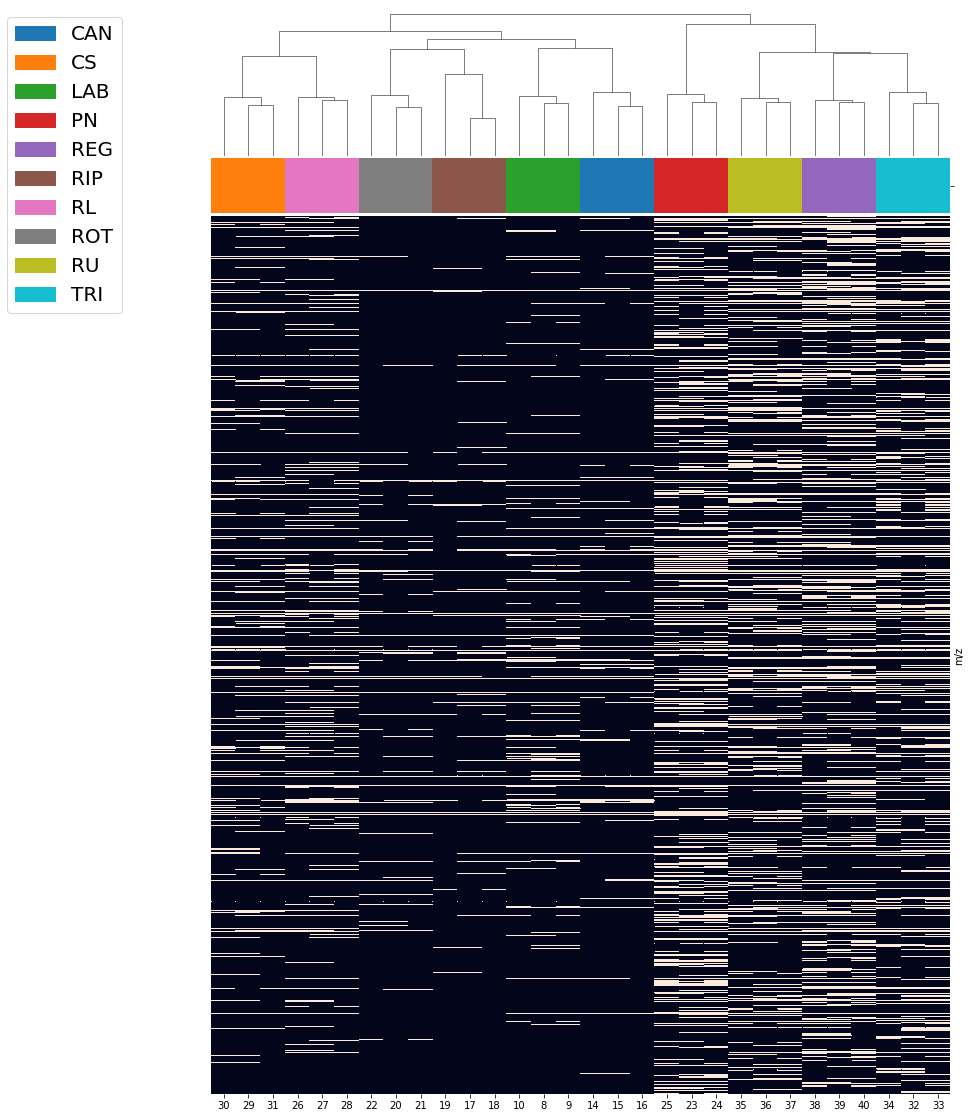

In [18]:
print('Sample HC, POSITIVE mode')
g = clustermap_peak_list(aligned_all_pos)
g.savefig('sampleHC_positive.pdf')

Cultivar dendogram, Jaccard distance, NEGATIVE MODE


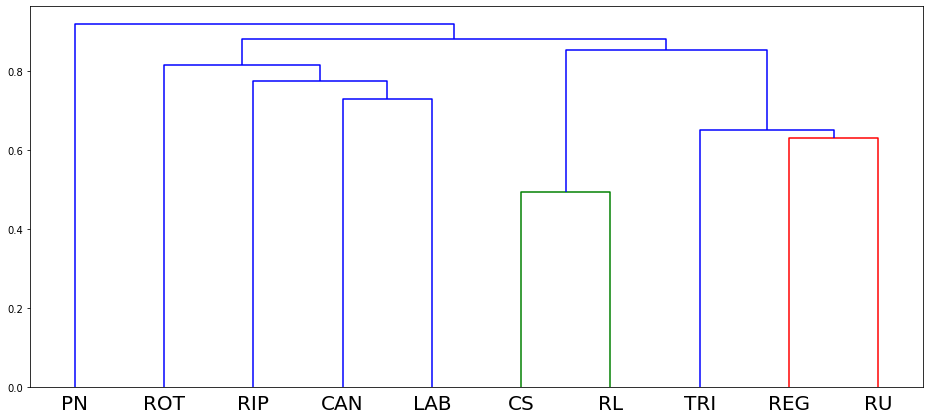

In [19]:
print('Cultivar dendogram, Jaccard distance, NEGATIVE MODE')
jdist = dist.squareform(1 - sim_neg.label_similarity_jaccard)
Z = hier.linkage(jdist, method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z, labels=sim_neg.unique_labels,
                     leaf_font_size=20,
                     above_threshold_color='b')
fig.savefig('dendo_cultivars_jaccard_negative.pdf')

In [20]:
print(hier.cophenet(Z,jdist)[0])

0.9209358373807722


Cultivar dendogram, Jaccard distance, POSITIVE MODE


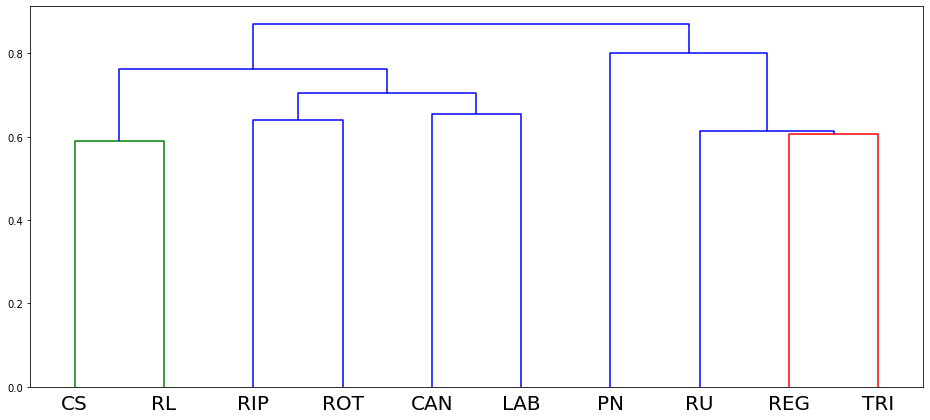

In [21]:
print('Cultivar dendogram, Jaccard distance, POSITIVE MODE')
jdist = dist.squareform(1 - sim_pos.label_similarity_jaccard)
Z = hier.linkage(jdist, method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z, labels=sim_pos.unique_labels,
                     leaf_font_size=20,
                     above_threshold_color='b')
fig.savefig('dendo_cultivars_jaccard_positive.pdf')

In [22]:
print(hier.cophenet(Z,jdist)[0])

0.9177776331679081


### Other Binary Similarity Analysis Methods

In [23]:
aligned_neg = df_to_bool(aligned_all_neg.data)
aligned_pos = df_to_bool(aligned_all_pos.data)

Creating the colours label for all dendrograms (negative and positive have the same labels):

In [24]:
label_colors = {}
colours = cm.get_cmap('nipy_spectral', 10)
col_lbl = colours(range(10))
for i in range(len(col_lbl)):
    label_colors[aligned_all_neg.labels[3*i]] = col_lbl[i]

Cultivar dendogram, Binary methods, NEGATIVE MODE


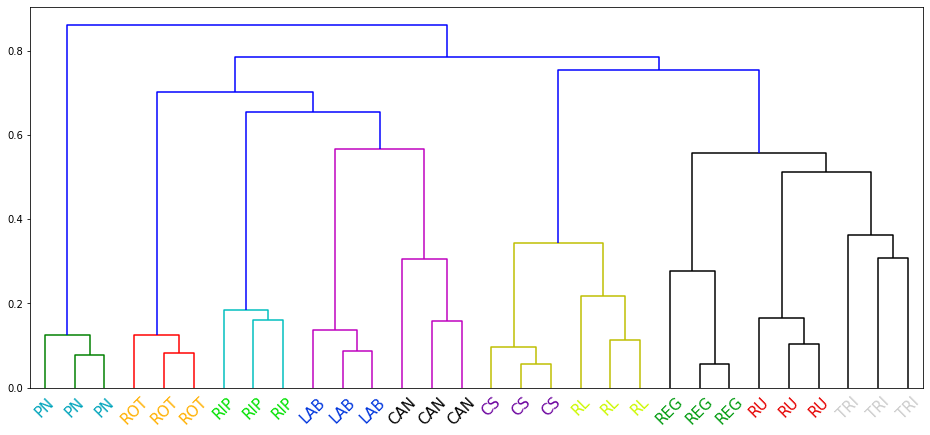

In [25]:
#Apply one of the following:
#dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule
#kulsinski, rusellrao

print('Cultivar dendogram, Binary methods, NEGATIVE MODE')
Zdice_neg = hier.linkage(aligned_neg.T, metric = 'dice', method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Zdice_neg, labels=aligned_all_neg.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

Cultivar dendogram, Binary methods, POSITIVE MODE


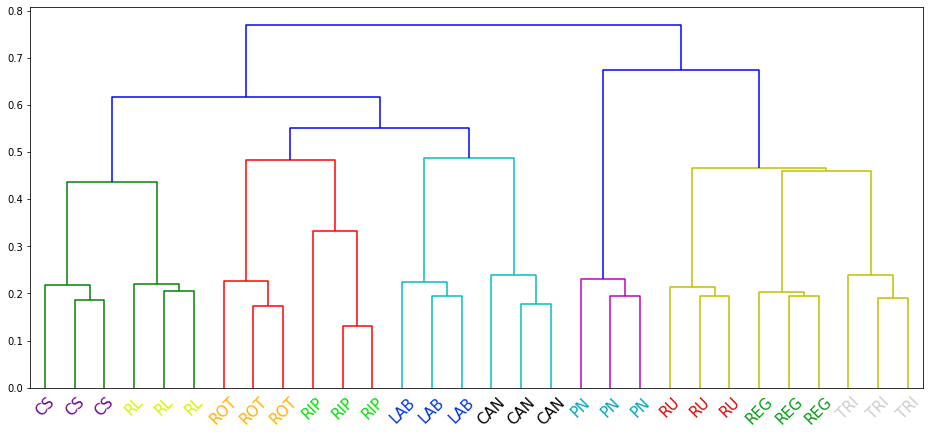

In [26]:
print('Cultivar dendogram, Binary methods, POSITIVE MODE')
Zdice_pos = hier.linkage(aligned_pos.T, metric = 'dice', method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Zdice_pos, labels=aligned_all_pos.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

### Non-binary Similarity Analysis

#### Missing Value Imputation and Scaling (Pareto Scaling), Euclidean Distances and Dendrogram Construction


In [27]:
import scaling as sca
import numpy as np

#### Negative Mode - Original peak alignment

3 types of processing:

Euc_neg - Missing Value Imputation and Pareto Scaling.

Euc_norm_neg - Missing Value Imputation, Normalization by reference feature and Pareto Scaling.

Euc_glog_neg - Missing Value Imputation, Normalization by reference feature, glog transformation and Pareto Scaling.

In [28]:
#Euc_neg
Imputated_neg = sca.NaN_Imputation(aligned_all_neg, 0.00001)
Euc_neg = sca.ParetoScal(Imputated_neg)

Cultivar dendogram, Euclidean distance, NEGATIVE MODE, NaN Imputation and Pareto Scaling


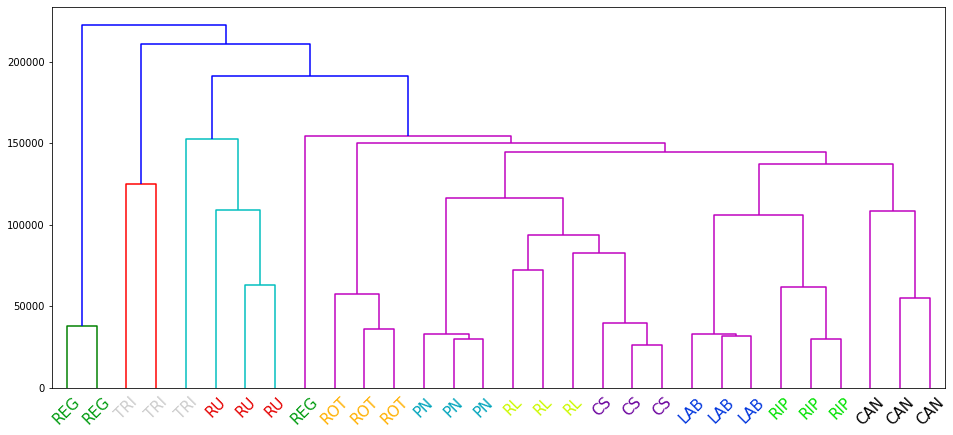

In [29]:
#Measure Euclidean distances
dist_euc_neg = dist.pdist(Euc_neg.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, NEGATIVE MODE, NaN Imputation and Pareto Scaling')
Z_euc_neg = hier.linkage(dist_euc_neg, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_neg, labels=Euc_neg.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [30]:
#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
print(hier.cophenet(Z_euc_neg,dist_euc_neg)[0]) #method average seems to lead to higher coefficients

0.9195827620011211


In [31]:
#Euc_norm_neg
#Theoretical mass for negative mode Leucine Enkephalin - 554.2615.
RefEst_Neg = sca.search_for_ref_feat(aligned_all_neg, 554.2615) #see if the function gives the reference feature
print(RefEst_Neg) #It did!

(554.26202, 0.0005200000000513683)


In [32]:
Norm_neg = sca.Norm_Feat(Imputated_neg, 554.26202)
Euc_norm_neg = sca.ParetoScal(Norm_neg)

Cultivar dendogram, Euclidean distance, NEGATIVE MODE, NaN Imputation, Normalized and Pareto Scaling


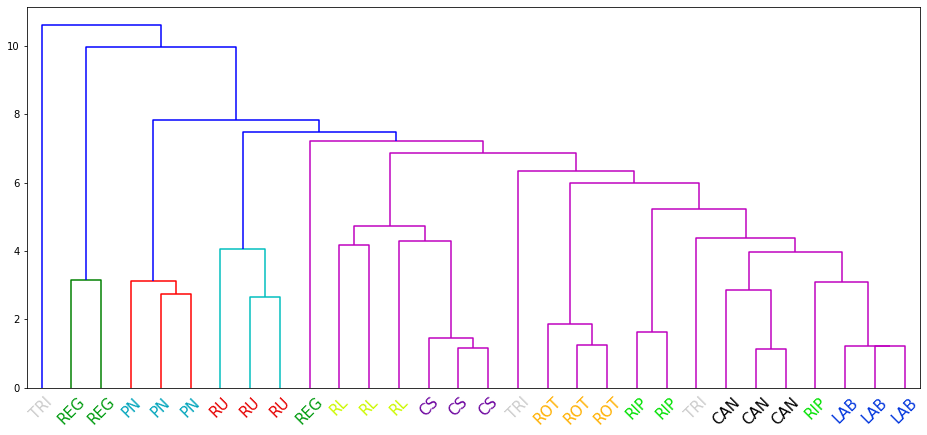

In [33]:
#Measure Euclidean distances
dist_euc_norm_neg = dist.pdist(Euc_norm_neg.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, NEGATIVE MODE, NaN Imputation, Normalized and Pareto Scaling')
Z_euc_norm_neg = hier.linkage(dist_euc_norm_neg, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_norm_neg, labels=Euc_norm_neg.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [34]:
print(hier.cophenet(Z_euc_norm_neg,dist_euc_norm_neg)[0]) 

0.8947920259447498


In [35]:
#Euc_glog_neg
glog_neg = sca.glog(Norm_neg, 0)
Euc_glog_neg = sca.ParetoScal(glog_neg)

Cultivar dendogram, Euclidean distance, NEGATIVE MODE, NaN Imputation, Normalized, Transformed and Pareto Scaling


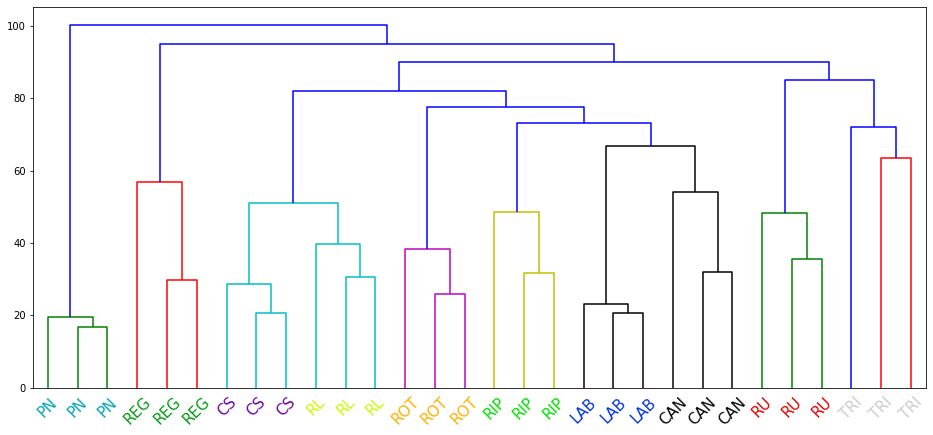

In [36]:
#Measure Euclidean distances
dist_euc_glog_neg = dist.pdist(Euc_glog_neg.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, NEGATIVE MODE, NaN Imputation, Normalized, Transformed and Pareto Scaling')
Z_euc_glog_neg = hier.linkage(dist_euc_glog_neg, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_glog_neg, labels=Euc_glog_neg.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [37]:
print(hier.cophenet(Z_euc_glog_neg,dist_euc_glog_neg)[0]) 

0.8505203164692614


#### Positive Mode - Original peak alignment

3 types of processing:

Euc_pos - Missing Value Imputation and Pareto Scaling.

Euc_norm_pos - Missing Value Imputation, Normalization by reference feature and Pareto Scaling.

Euc_glog_pos - Missing Value Imputation, Normalization by reference feature, glog transformation and Pareto Scaling.

In [38]:
#Euc_pos
Imputated_pos = sca.NaN_Imputation(aligned_all_pos, 0.00001)
Euc_pos = sca.ParetoScal(Imputated_pos)

Cultivar dendogram, Euclidean distance, POSITIVE MODE, NaN Imputation and Pareto Scaling


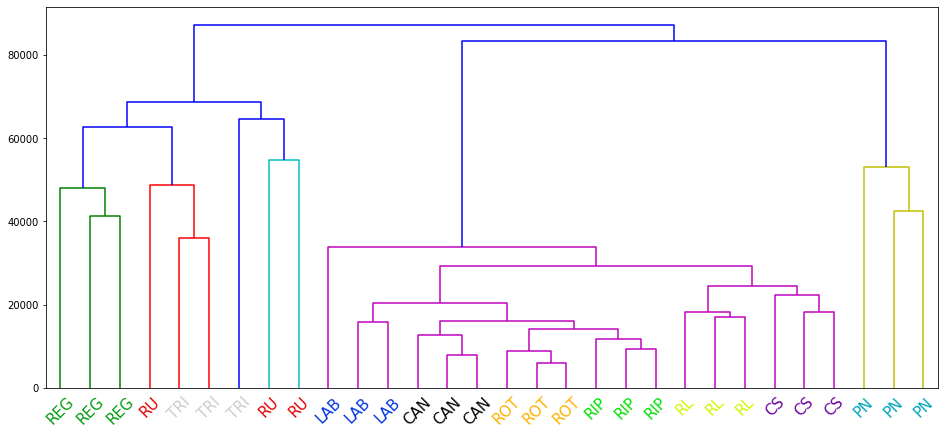

In [39]:
#Measure Euclidean distances
dist_euc_pos = dist.pdist(Euc_pos.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, POSITIVE MODE, NaN Imputation and Pareto Scaling')
Z_euc_pos = hier.linkage(dist_euc_pos, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_pos, labels=Euc_pos.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [40]:
print(hier.cophenet(Z_euc_pos,dist_euc_pos)[0])

0.9761517084498552


In [41]:
#Euc_norm_pos
#Theoretical mass for positive mode Leucine Enkephalin - 556.2771.
RefEst_Pos = sca.search_for_ref_feat(aligned_all_pos, 556.2771)
print(RefEst_Pos)

(556.2765712820513, 0.0005287179486686)


In [42]:
Norm_pos = sca.Norm_Feat(Imputated_pos, 556.2765712820513)
Euc_norm_pos = sca.ParetoScal(Norm_pos)

Cultivar dendogram, Euclidean distance, POSITIVE MODE, NaN Imputation, Normalized and Pareto Scaling


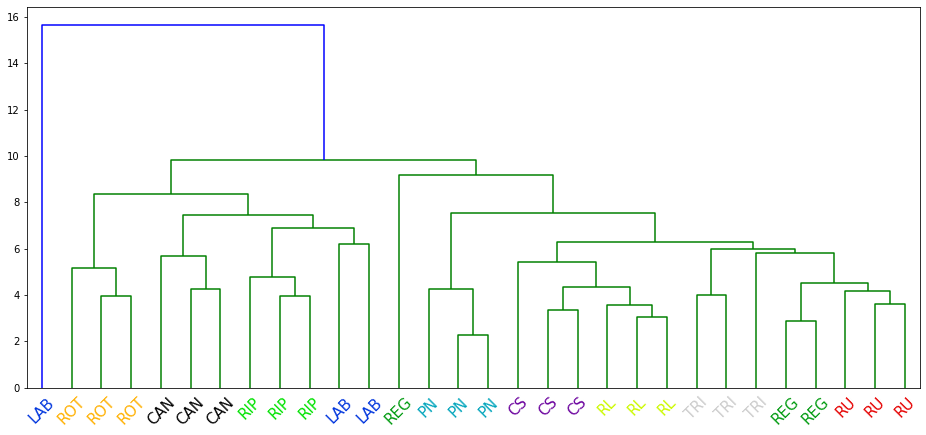

In [43]:
#Measure Euclidean distances
dist_euc_norm_pos = dist.pdist(Euc_norm_pos.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, POSITIVE MODE, NaN Imputation, Normalized and Pareto Scaling')
Z_euc_norm_pos = hier.linkage(dist_euc_norm_pos, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_norm_pos, labels=Euc_norm_pos.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [44]:
print(hier.cophenet(Z_euc_norm_pos,dist_euc_norm_pos)[0])

0.8569581728873317


In [45]:
#Euc_glog_pos
glog_pos = sca.glog(Norm_pos, 0)
Euc_glog_pos = sca.ParetoScal(glog_pos)

Cultivar dendogram, Euclidean distance, POSITIVE MODE, NaN Imputation, Normalized, Transformed and Pareto Scaling


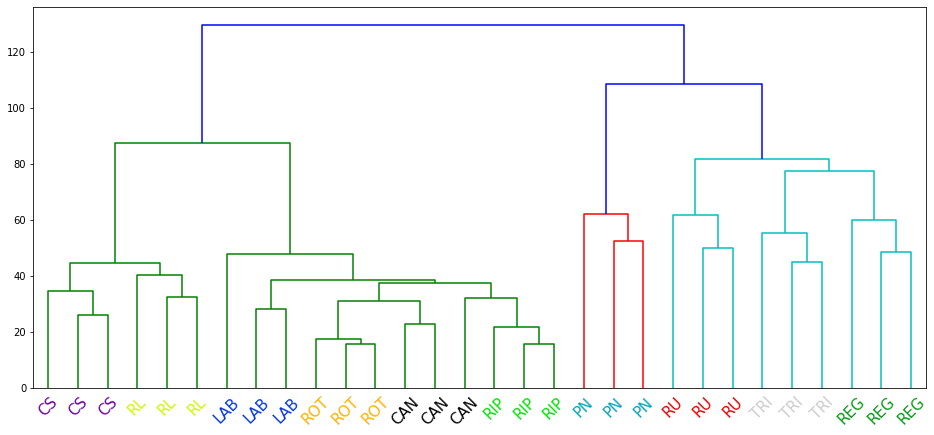

In [46]:
#Measure Euclidean distances
dist_euc_glog_pos = dist.pdist(Euc_glog_pos.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, POSITIVE MODE, NaN Imputation, Normalized, Transformed and Pareto Scaling')
Z_euc_glog_pos = hier.linkage(dist_euc_glog_pos, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_glog_pos, labels=Euc_glog_pos.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [47]:
print(hier.cophenet(Z_euc_glog_pos,dist_euc_glog_pos)[0])

0.8432476740413934


## 2nd Peak Alignment - 3-3

#### Negative Mode - Peak alignment (requires a feature to be present in all samples of at least one variety)

Same procedure as before:

3 types of processing:

Euc_neg2 (in script, 3_3 in figures) - Missing Value Imputation and Pareto Scaling.

Euc_norm_neg2 (in script, 3_3 in figures) - Missing Value Imputation, Normalization by reference feature and Pareto Scaling.

Euc_glog_neg2 (in script, 3_3 in figures) - Missing Value Imputation, Normalization by reference feature, glog transformation and Pareto Scaling.

In [48]:
aligned_all_pos2_f = read_aligned_spectra('aligned_1ppm_min3-3_1ppm_positive.csv', labels=True, sep=',')
aligned_all_neg2_f = read_aligned_spectra('aligned_1ppm_min3-3_1ppm_negative.csv', labels=True, sep=',')

de_neg2 = aligned_all_neg2_f.data
de_neg2 = de_neg2[["14","15","16","29","30","31","8","9","10","23","24","25","38","39","40","17","18","19","26","27","28","20","21","22","35","36","37","32","33","34"]]
aligned_all_neg2 = AlignedSpectra(de_neg2, labels=["CAN","CAN","CAN","CS","CS","CS","LAB","LAB","LAB","PN","PN","PN","REG","REG","REG","RIP","RIP","RIP","RL","RL","RL","ROT","ROT","ROT","RU","RU","RU","TRI","TRI","TRI"])

de_pos2 = aligned_all_pos2_f.data
de_pos2 = de_pos2[["14","15","16","29","30","31","8","9","10","23","24","25","38","39","40","17","18","19","26","27","28","20","21","22","35","36","37","32","33","34"]]
aligned_all_pos2 = AlignedSpectra(de_pos2, labels=["CAN","CAN","CAN","CS","CS","CS","LAB","LAB","LAB","PN","PN","PN","REG","REG","REG","RIP","RIP","RIP","RL","RL","RL","ROT","ROT","ROT","RU","RU","RU","TRI","TRI","TRI"])

In [49]:
#Euc_neg2
Imputated_neg2 = sca.NaN_Imputation(aligned_all_neg2, 0.00001)
Euc_neg2 = sca.ParetoScal(Imputated_neg2)

Cultivar dendogram, Euclidean distance, NEGATIVE MODE, Peak Alignment: 3-3, NaN Imputation and Pareto Scaling


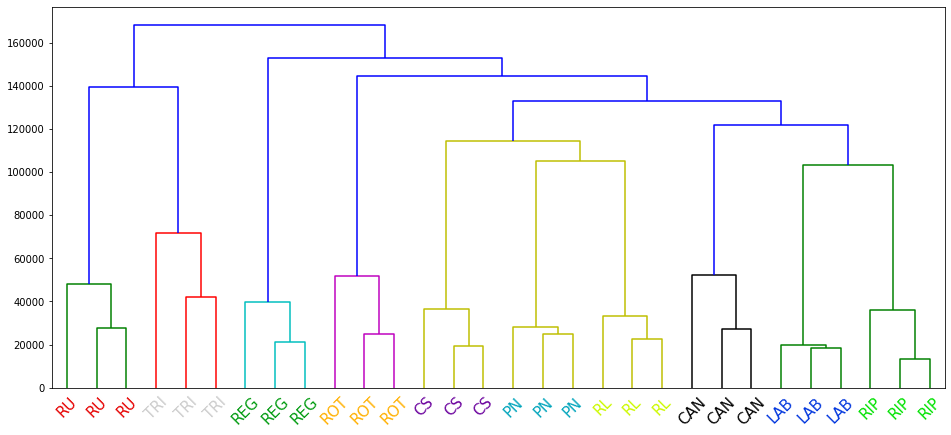

In [50]:
#Measure Euclidean distances
import scipy.spatial.distance as dist
dist_euc_neg2 = dist.pdist(Euc_neg2.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, NEGATIVE MODE, Peak Alignment: 3-3, NaN Imputation and Pareto Scaling')
Z_euc_neg2 = hier.linkage(dist_euc_neg2, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_neg2, labels=Euc_neg2.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [51]:
print(hier.cophenet(Z_euc_neg2,dist_euc_neg2)[0]) 

0.8346922779809163


In [52]:
#Euc_norm_neg2
#Theoretical mass for negative mode Leucine Enkephalin - 554.2615.
RefEst_Pos = sca.search_for_ref_feat(aligned_all_neg2, 554.2615)
print(RefEst_Pos) #Same result as previous alignment.
Norm_neg2 = sca.Norm_Feat(Imputated_neg2, 554.26202)
Euc_norm_neg2 = sca.ParetoScal(Norm_neg2)

(554.26202, 0.0005200000000513683)


Cultivar dendogram, Euclidean distance, NEGATIVE MODE, Peak Alignment: 3-3, NaN Imputation, Normalized and Pareto Scaling


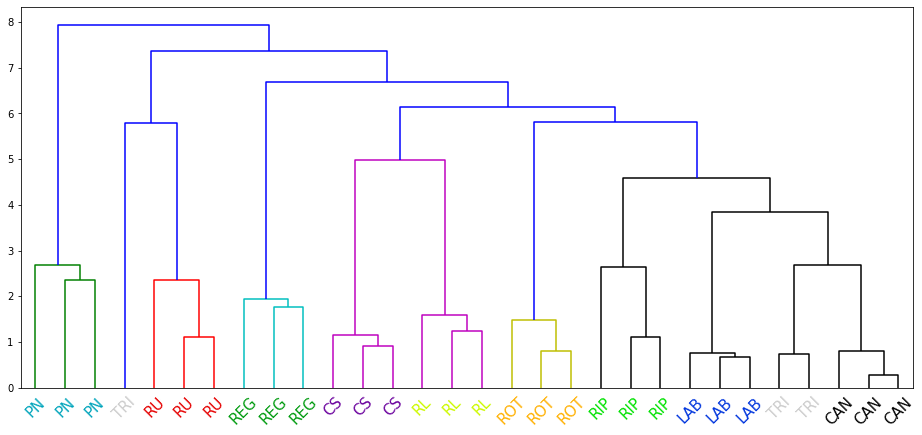

In [53]:
#Measure Euclidean distances
dist_euc_norm_neg2 = dist.pdist(Euc_norm_neg2.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, NEGATIVE MODE, Peak Alignment: 3-3, NaN Imputation, Normalized and Pareto Scaling')
Z_euc_norm_neg2 = hier.linkage(dist_euc_norm_neg2, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_norm_neg2, labels=Euc_norm_neg2.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [54]:
print(hier.cophenet(Z_euc_norm_neg2,dist_euc_norm_neg2)[0])

0.8829687860341574


In [55]:
#Euc_glog_neg2
glog_neg2 = sca.glog(Norm_neg2, 0)
Euc_glog_neg2 = sca.ParetoScal(glog_neg2)

Cultivar dendogram, Euclidean distance, NEGATIVE MODE, Peak Alignment: 3-3, NaN Imputation, Normalized, Transformed and Pareto Scaling


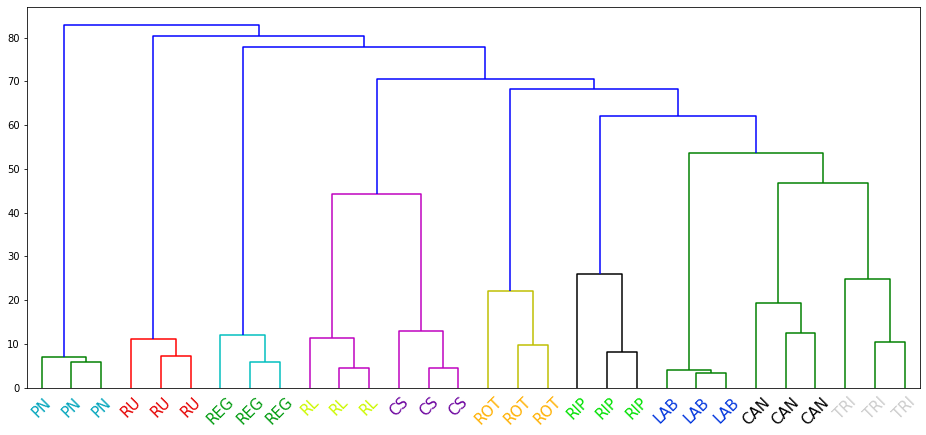

In [56]:
#Measure Euclidean distances
dist_euc_glog_neg2 = dist.pdist(Euc_glog_neg2.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, NEGATIVE MODE, Peak Alignment: 3-3, NaN Imputation, Normalized, Transformed and Pareto Scaling')
Z_euc_glog_neg2 = hier.linkage(dist_euc_glog_neg2, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_glog_neg2, labels=Euc_glog_neg2.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [57]:
print(hier.cophenet(Z_euc_glog_neg2,dist_euc_glog_neg2)[0]) #method average seems to lead to higher coefficients

0.9227830612845037


#### Positive Mode - Peak alignment (requires a feature to be present in at least all samples of a variety)

Same procedure as before:

3 types of processing:

Euc_pos2 (in script, 3_3 in figures) - Missing Value Imputation and Pareto Scaling.

Euc_norm_pos2 (in script, 3_3 in figures) - Missing Value Imputation, Normalization by reference feature and Pareto Scaling.

Euc_glog_pos2 (in script, 3_3 in figures) - Missing Value Imputation, Normalization by reference feature, glog transformation and Pareto Scaling

In [58]:
#Euc_pos2
Imputated_pos2 = sca.NaN_Imputation(aligned_all_pos2, 0.00001)
Euc_pos2 = sca.ParetoScal(Imputated_pos2)

Cultivar dendogram, Euclidean distance, POSITIVE MODE, Peak Alignment: 3-3, NaN Imputation and Pareto Scaling


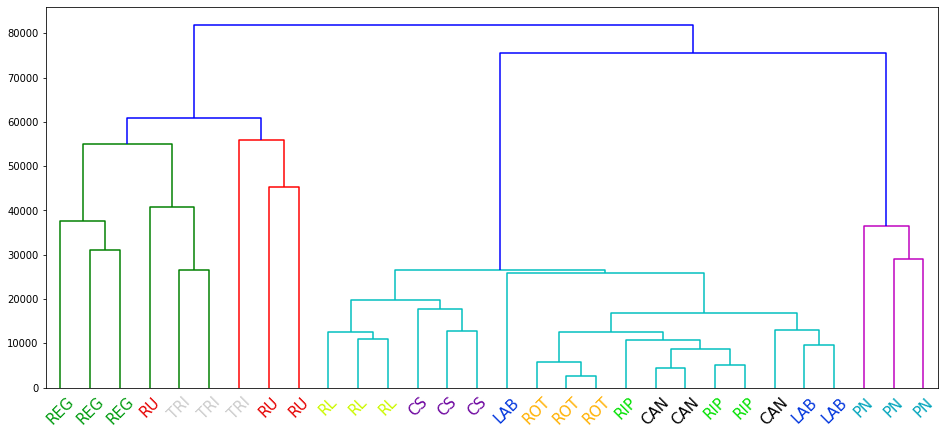

In [59]:
#Measure Euclidean distances
dist_euc_pos2 = dist.pdist(Euc_pos2.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, POSITIVE MODE, Peak Alignment: 3-3, NaN Imputation and Pareto Scaling')
Z_euc_pos2 = hier.linkage(dist_euc_pos2, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_pos2, labels=Euc_pos2.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [60]:
print(hier.cophenet(Z_euc_pos2,dist_euc_pos2)[0])

0.9737785566392584


In [61]:
#Euc_norm_pos2
#Theoretical mass for positive mode Leucine Enkephalin - 556.2771.
RefEst_Pos = sca.search_for_ref_feat(aligned_all_pos, 556.2771)
print(RefEst_Pos) #Same result as previous alignment.
Norm_pos2 = sca.Norm_Feat(Imputated_pos2, 556.2765712820513)
Euc_norm_pos2 = sca.ParetoScal(Norm_pos2)

(556.2765712820513, 0.0005287179486686)


Cultivar dendogram, Euclidean distance, POSITIVE MODE, Peak Alignment: 3-3, NaN Imputation, Normalized and Pareto Scaling


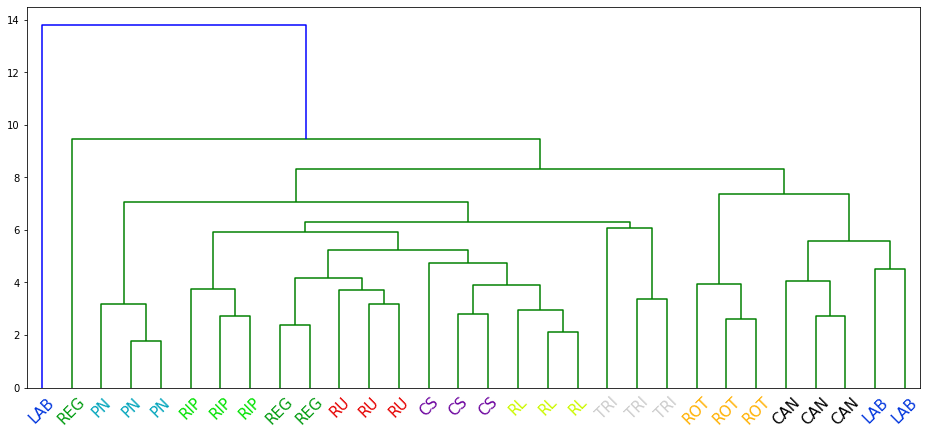

In [62]:
#Measure Euclidean distances
dist_euc_norm_pos2 = dist.pdist(Euc_norm_pos2.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, POSITIVE MODE, Peak Alignment: 3-3, NaN Imputation, Normalized and Pareto Scaling')
Z_euc_norm_pos2 = hier.linkage(dist_euc_norm_pos2, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_norm_pos2, labels=Euc_norm_pos2.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [63]:
print(hier.cophenet(Z_euc_norm_pos2,dist_euc_norm_pos2)[0])

0.8778201042767924


In [64]:
#Euc_glog_pos
glog_pos2 = sca.glog(Norm_pos2, 0)
Euc_glog_pos2 = sca.ParetoScal(glog_pos2)

Cultivar dendogram, Euclidean distance, POSITIVE MODE, Peak Alignment: 3-3, NaN Imputation, Normalized, Transformed and Pareto Scaling


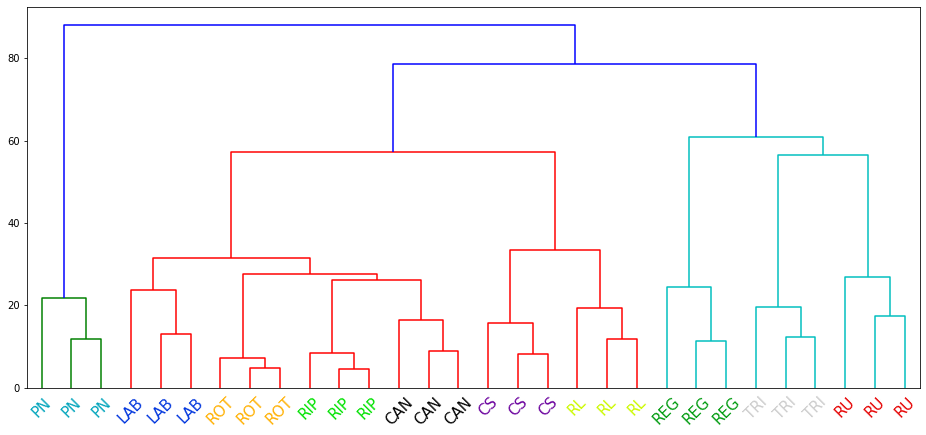

In [65]:
#Measure Euclidean distances
dist_euc_glog_pos2 = dist.pdist(Euc_glog_pos2.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Cultivar dendogram, Euclidean distance, POSITIVE MODE, Peak Alignment: 3-3, NaN Imputation, Normalized, Transformed and Pareto Scaling')
Z_euc_glog_pos2 = hier.linkage(dist_euc_glog_pos2, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_glog_pos2, labels=Euc_glog_pos2.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [66]:
print(hier.cophenet(Z_euc_glog_pos2,dist_euc_glog_pos2)[0])

0.9046885644266938


### Comparing Dendrograms

#### Two methods so far: Baker's Gamma Correlation and Cophenetic Correlation Coefficient

#### Examples of procedure with these methods

In [67]:
import numpy as np
import scipy.stats as stats

#### Baker's method

In [68]:

def mergerank(Z):
    """Creates a 'rank' of the iteration number two samples were linked to the same cluster.
       
       Z: 2-D array; the return of the linkage function in scypy.stats.hierarchy.
       Returns: Matrix/2-D array; Symmetrical Square Matrix (dimensions: len(Z)+1 by len(Z)+1), (i,j) position is the iteration 
    number sample i and j were linked to the same cluster (higher rank means the pair took more iterations to be linked together).
    """
    
    kmatrix = np.zeros((len(Z)+1, len(Z)+1))
    clust = {}
    for i in range(0,len(Z)+1):
        clust[i] = (float(i),)
    for r in range(0,len(Z)):
        if Z[r,0] < len(Z)+1 and Z[r,1] < len(Z)+1:
            kmatrix[int(Z[r,0]),int(Z[r,1])] = r+1
            kmatrix[int(Z[r,1]),int(Z[r,0])] = r+1
            clust[len(Z)+1+r] = Z[r,0],Z[r,1] #Dictionary with the elements in the cluster formed at iteration r. - r: (elements)
        else:
            clust[len(Z)+1+r] = clust[Z[r,0]] + clust[Z[r,1]] #Dictionary with the elements in the cluster formed at iteration r.
            for i in range(0,len(clust[Z[r,0]])):
                for j in range(0,len(clust[Z[r,1]])):
                    kmatrix[int(clust[Z[r,0]][i]),int(clust[Z[r,1]][j])] = r+1
                    kmatrix[int(clust[Z[r,1]][j]),int(clust[Z[r,0]][i])] = r+1
    return kmatrix


In [69]:
euclidean = (Z_euc_neg, Z_euc_norm_neg, Z_euc_glog_neg, Z_euc_pos, Z_euc_norm_pos, Z_euc_glog_pos,
            Z_euc_neg2, Z_euc_norm_neg2, Z_euc_glog_neg2, Z_euc_pos2, Z_euc_norm_pos2, Z_euc_glog_pos2)
dist_euclidean = (dist_euc_neg, dist_euc_norm_neg, dist_euc_glog_neg, dist_euc_pos, dist_euc_norm_pos, dist_euc_glog_pos,
                 dist_euc_neg2, dist_euc_norm_neg2, dist_euc_glog_neg2, dist_euc_pos2, dist_euc_norm_pos2, dist_euc_glog_pos2)

K_euc = []
S_euc = []
Coph_euc = []

for i in range(len(euclidean)):
    K_euc.append(mergerank(euclidean[i])) #Mergerank
    S_euc.append(K_euc[i][K_euc[i]!=0]) #Both reshape to a 1D array (needed for spearman correlation) and take out 0's 
    Coph_euc.append(hier.cophenet(euclidean[i], dist_euclidean[i])) #Matrix of Cophenetic distances

#### Examples

According to Original Paper (Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors)

In [70]:
print('Pair of samples      \tKendall Correlation \tp-value')
print('Euc_neg-Euc_norm_neg\t', stats.kendalltau(S_euc[0],S_euc[1])[0], '\t', stats.kendalltau(S_euc[0],S_euc[1])[1])
print('Euc_neg-Euc_glog_neg\t', stats.kendalltau(S_euc[0],S_euc[2])[0], '\t', stats.kendalltau(S_euc[0],S_euc[2])[1])

Pair of samples      	Kendall Correlation 	p-value
Euc_neg-Euc_norm_neg	 0.49770594785189787 	 2.841436241688467e-86
Euc_neg-Euc_glog_neg	 0.4057982056831566 	 4.601042303188374e-56


According to the explanation given in the R package dendextend

In [71]:
print('Pair of samples      \tSpearman Correlation \tp-value')
print('Euc_neg-Euc_norm_neg\t', stats.spearmanr(S_euc[0],S_euc[1])[0], '\t', stats.spearmanr(S_euc[0],S_euc[1])[1])
print('Euc_neg-Euc_glog_neg\t', stats.spearmanr(S_euc[0],S_euc[2])[0], '\t', stats.spearmanr(S_euc[0],S_euc[2])[1])

Pair of samples      	Spearman Correlation 	p-value
Euc_neg-Euc_norm_neg	 0.6240662692699944 	 4.333842792048118e-95
Euc_neg-Euc_glog_neg	 0.46485036761576476 	 7.515824325455241e-48


#### Cophenetic Correlation Coefficient

In [72]:
#Acho que se pode aplicar logo a função np.corrcoef visto os elementos que vêm da função cophenet estão sempre na mesma ordem 
#uns em relação aos outros.

In [73]:
print('Pair of samples      \tPearson Correlation \tp-value')
print('Euc_neg-Euc_norm_neg\t', stats.pearsonr(Coph_euc[0][1],Coph_euc[1][1])[0], '\t', stats.pearsonr(Coph_euc[0][1],Coph_euc[1][1])[1])
print('Euc_neg-Euc_glog_neg\t', stats.pearsonr(Coph_euc[0][1],Coph_euc[2][1])[0], '\t', stats.pearsonr(Coph_euc[0][1],Coph_euc[2][1])[1])

Pair of samples      	Pearson Correlation 	p-value
Euc_neg-Euc_norm_neg	 0.7616472733366593 	 1.2899791846294668e-83
Euc_neg-Euc_glog_neg	 0.6931109766422806 	 1.5255530344119417e-63


### Comparison of dendrograms made with all binary metrics and euclidean distances 

#### Correlations between all pairs using all 3 methods

In [74]:
#9 binary methods accepted in pdist (scipy.spatial.distances.pdist)
binary = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 'yule', 'kulsinski', 'russellrao')

In [75]:
#Application of all "single" steps needed presented in the examples above with every distance metric.
#Negative mode
Z_neg = []
K_neg = []
S_neg = []
Coph_neg = []

for i in range(len(binary)):
    Z_neg.append(hier.linkage(aligned_neg.T, metric = binary[i], method='average')) #Z
    K_neg.append(mergerank(Z_neg[i])) #Mergerank
    S_neg.append(K_neg[i][K_neg[i]!=0]) #Eliminating 0's
    Coph_neg.append(hier.cophenet(Z_neg[i], dist.pdist(aligned_neg.T, metric = binary[i]))) #Cophenetic

In [76]:
#Positive Mode
Z_pos = []
K_pos = []
S_pos = []
Coph_pos = []

for i in range(len(binary)):
    Z_pos.append(hier.linkage(aligned_pos.T, metric = binary[i], method='average')) #Z
    K_pos.append(mergerank(Z_pos[i])) #Mergerank
    S_pos.append(K_pos[i][K_pos[i]!=0]) #Eliminating 0's
    Coph_pos.append(hier.cophenet(Z_pos[i], dist.pdist(aligned_pos.T, metric = binary[i]))) #Cophenetic

In [77]:
#Creation of a list with all the "rank" values (in order) for the different metrics: 
#Negative Euclideans, Positive Euclideans, Negative Binaries, Positive Binaries
S = []
S.extend(S_euc)
S.extend(S_neg)
S.extend(S_pos)
#Creation of a list with all the returns from the function cophenetic for the different metrics: 
#Negative Euclideans, Positive Euclideans, Negative Binaries, Positive Binaries
Coph = []
Coph.extend(Coph_euc)
Coph.extend(Coph_neg)
Coph.extend(Coph_pos)

Creation of all dataframes needed to store all correlation coeficients and respective p-values fot all three methods

In [78]:
#Column names and row names for the dataframes
colnames = ['euc_neg', 'euc_norm_neg', 'euc_glog_neg', 'euc_pos', 'euc_norm_pos', 'euc_glog_pos','euc_neg3_3', 'euc_norm_neg3_3', 
            'euc_glog_neg3_3', 'euc_pos3_3', 'euc_norm_pos3_3', 'euc_glog_pos3_3','dice_neg', 'hamming_neg', 'jaccard_neg', 
            'rogerstanimoto_neg', 'sokalmichener_neg', 'sokalsneath_neg','yule_neg', 'kulsinski_neg', 'russellrao_neg',
            'dice_pos', 'hamming_pos', 'jaccard_pos', 'rogerstanimoto_pos', 'sokalmichener_pos', 'sokalsneath_pos', 
            'yule_pos', 'kulsinski_pos', 'russellrao_pos']

In [79]:
df_K = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #K - Kendall (Baker)
df_S = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #S - Spearman (Baker)
df_C = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #C - Cophenetic Correlation
df_K_p = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #p-values of K method
df_S_p = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #p-values of S method
df_C_p = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #p-values of C method

In [80]:
#Calculation of correlation coefficient for each method
for i in range(len(S)):
    for j in range(len(S)):
        df_K.iloc[i,j] = stats.kendalltau(S[i],S[j])[0] #Correlation coefficient
        df_S.iloc[i,j] = stats.spearmanr(S[i],S[j])[0] #Correlation coefficient
        df_C.iloc[i,j] = stats.pearsonr(Coph[i][1],Coph[j][1])[0] #Correlation coefficient
        df_K_p.iloc[i,j] = stats.kendalltau(S[i],S[j])[1] #p-value
        df_S_p.iloc[i,j] = stats.spearmanr(S[i],S[j])[1] #p-value
        df_C_p.iloc[i,j] = stats.pearsonr(Coph[i][1],Coph[j][1])[1] #p-value

### Heatmaps of the correlation coeficients for the 3 methods

Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc - Original peak alignment that all binary measures use (2-1)
Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


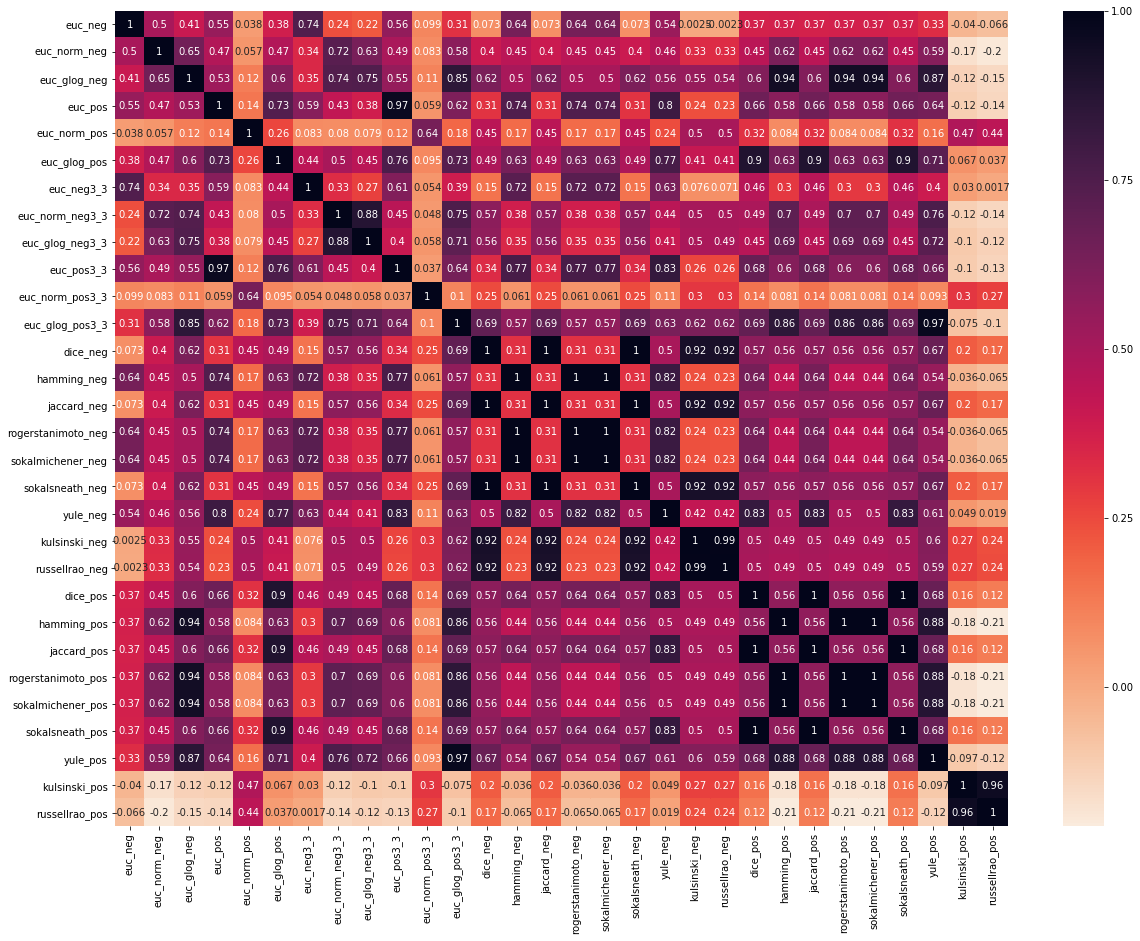

In [81]:
f, ax = plt.subplots(figsize=(20, 15))

print('Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc - Original peak alignment that all binary measures use (2-1)')
print('Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
hm = sns.heatmap(df_K, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [82]:
Kendall = pd.DataFrame(np.zeros((9, 5)), index = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 
                                                 'yule', 'kulsinski', 'russellrao'), columns = ('neg', 'pos', 'neg3_3', 'pos3_3',
                                                                                                 'neg+pos'))

for j in range(5):
    for r in range(9):
        if j in [0,2]:
            Kendall.iloc[r,j] = sum(df_K.iloc[12+r,j*3:j*3+3])
        elif j in [1,3]:
            Kendall.iloc[r,j] = sum(df_K.iloc[21+r,j*3:j*3+3])
        else:
            Kendall.iloc[r,j] = sum(Kendall.iloc[r,0:4])
#print(Kendall)

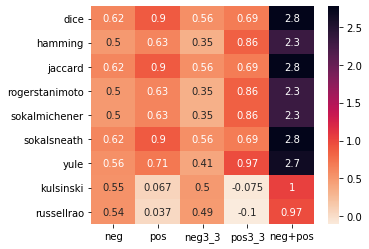

In [83]:
for j in range(5):
    for r in range(9):
        if j in [0,2]:
            Kendall.iloc[r,j] = df_K.iloc[12+r,j*3+2]#sum(df_C.iloc[12+r,j*3+2])j*3:j*3+3])
        elif j in [1,3]:
            Kendall.iloc[r,j] = df_K.iloc[21+r,j*3+2]#sum(df_C.iloc[21+r,j*3+2])j*3:j*3+3])
        else:
            Kendall.iloc[r,j] = sum(Kendall.iloc[r,0:4])
f, ax = plt.subplots(figsize=(5, 4))
hm = sns.heatmap(Kendall, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc - Original peak alignment that all binary measures use (2-1)
Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


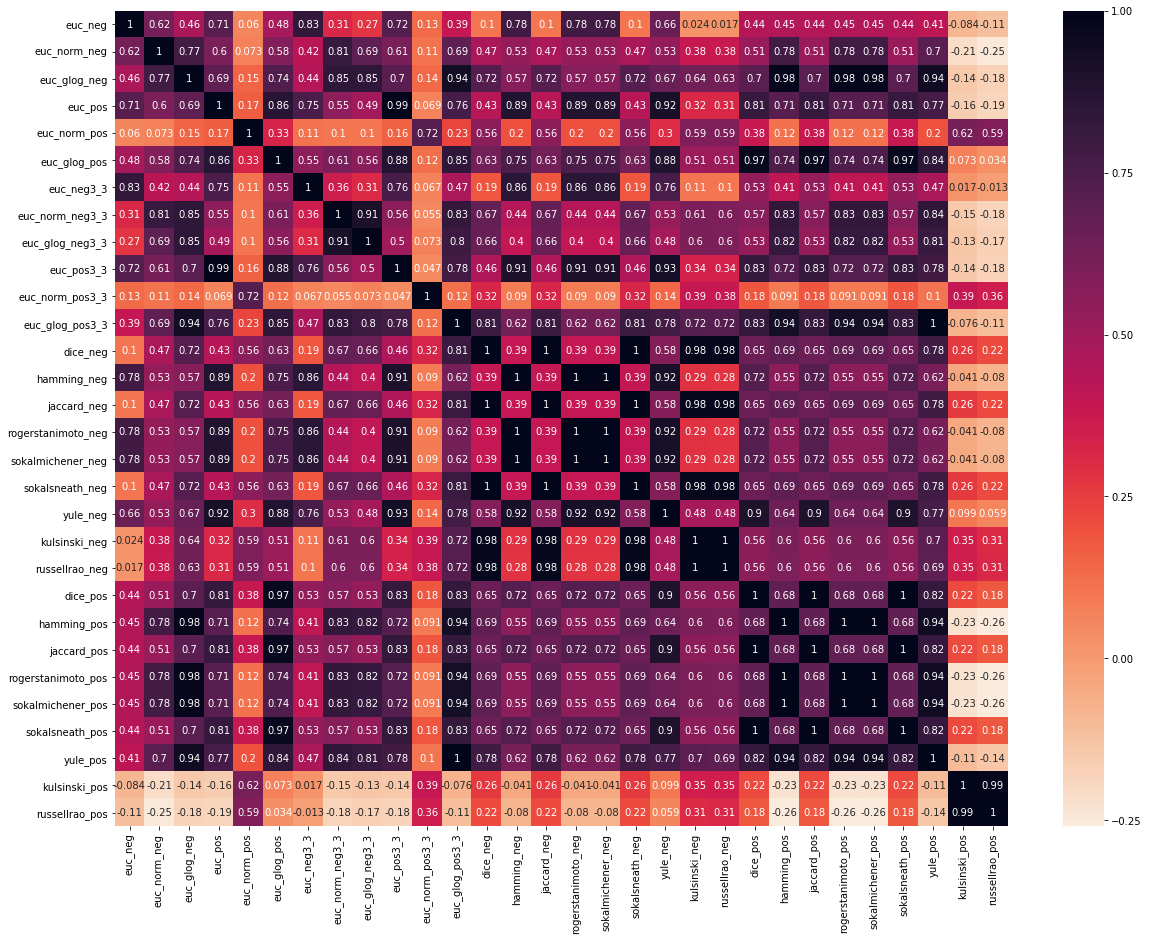

In [84]:
f, ax = plt.subplots(figsize=(20, 15))

print('Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc - Original peak alignment that all binary measures use (2-1)')
print('Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
hm = sns.heatmap(df_S, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc - Original peak alignment that all binary measures use (2-1)
Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


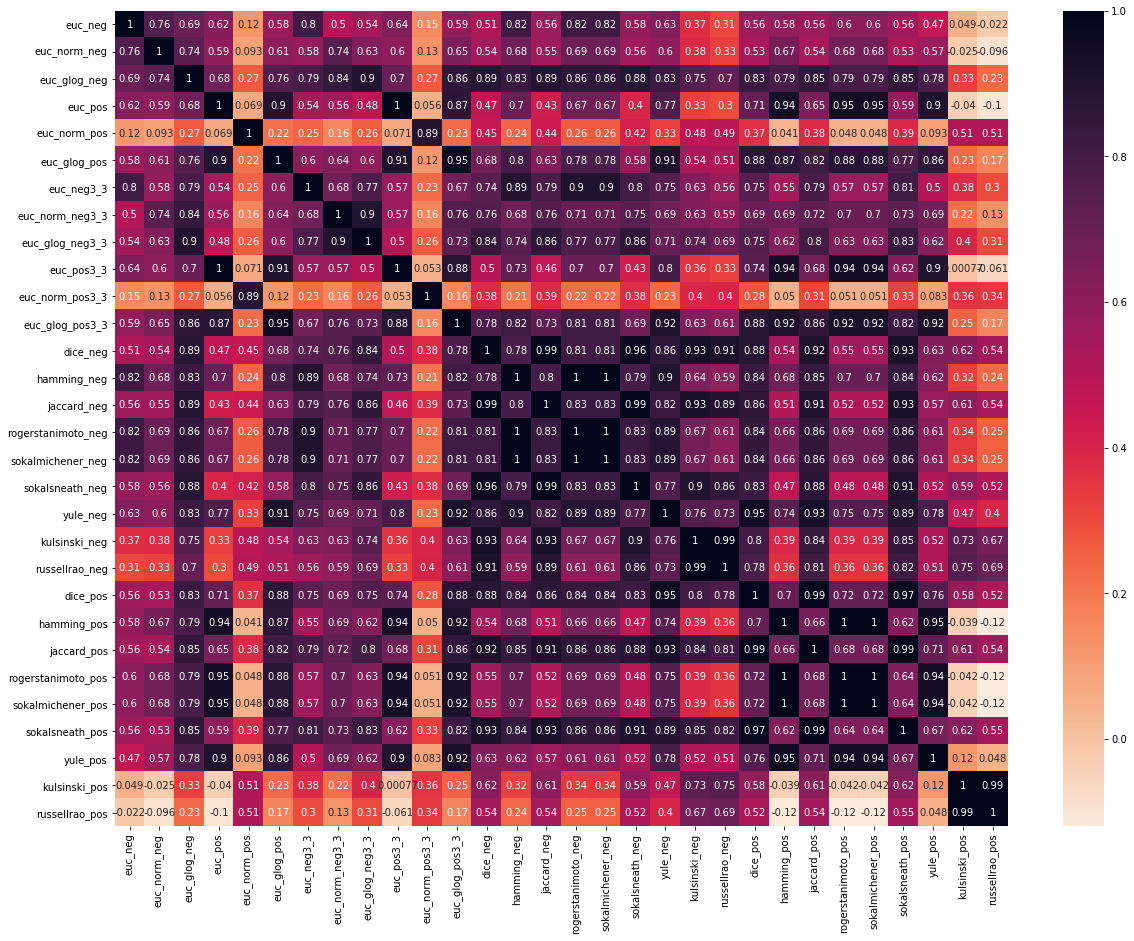

In [85]:
f, ax = plt.subplots(figsize=(20, 15))

print('Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc - Original peak alignment that all binary measures use (2-1)')
print('Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
hm = sns.heatmap(df_C, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [86]:
Cophenetic = pd.DataFrame(np.zeros((9, 5)), index = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 
                                                 'yule', 'kulsinski', 'russellrao'), columns = ('neg', 'pos', 'neg3_3', 'pos3_3',
                                                                                                 'neg+pos'))
for j in range(5):
    for r in range(9):
        if j in [0,2]:
            Cophenetic.iloc[r,j] = df_C.iloc[12+r,j*3+2]#sum(df_C.iloc[12+r,j*3+2])j*3:j*3+3])
        elif j in [1,3]:
            Cophenetic.iloc[r,j] = df_C.iloc[21+r,j*3+2]#sum(df_C.iloc[21+r,j*3+2])j*3:j*3+3])
        else:
            Cophenetic.iloc[r,j] = sum(Cophenetic.iloc[r,0:4])
#print(Cophenetic)

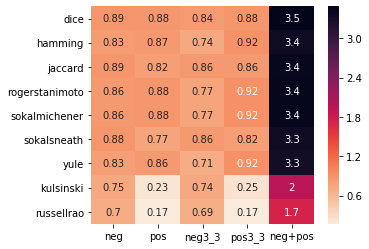

In [87]:
for j in range(5):
    for r in range(9):
        if j in [0,2]:
            Cophenetic.iloc[r,j] = df_C.iloc[12+r,j*3+2]#sum(df_C.iloc[12+r,j*3+2])j*3:j*3+3])
        elif j in [1,3]:
            Cophenetic.iloc[r,j] = df_C.iloc[21+r,j*3+2]#sum(df_C.iloc[21+r,j*3+2])j*3:j*3+3])
        else:
            Cophenetic.iloc[r,j] = sum(Cophenetic.iloc[r,0:4])
f, ax = plt.subplots(figsize=(5, 4))
hm = sns.heatmap(Cophenetic, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

### Hierarchical clustering of the correlation coeficients of dendrograms made with different distance metrics with each other

Colours for these labels (groups: neg_peakalignment1, pos_peakalignment1, neg_peakalignment2, pos_peakalignment2, neg_binary, pos_binary

In [88]:
label_colors2 = {}
colours2 = cm.get_cmap('nipy_spectral', 6)
col_lbl2 = colours2(range(6))
for i in range(4):
    label_colors2[df_K.columns[3*i]] = col_lbl2[i]
    label_colors2[df_K.columns[3*i+1]] = col_lbl2[i]
    label_colors2[df_K.columns[3*i+2]] = col_lbl2[i]
for i in range(9):
    label_colors2[df_K.columns[12+i]] = col_lbl2[4]
    label_colors2[df_K.columns[21+i]] = col_lbl2[5]

Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc - Original peak alignment that all binary measures use (2-1)
Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


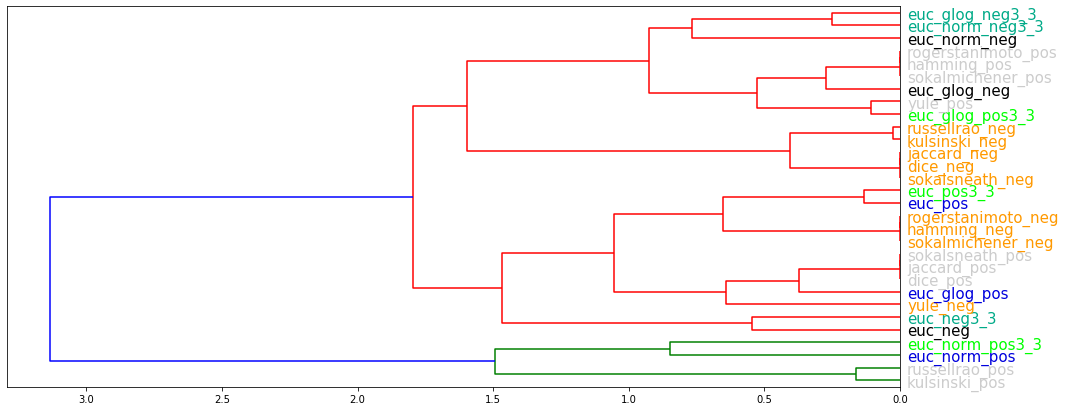

In [89]:
print('Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc - Original peak alignment that all binary measures use (2-1)')
print('Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
Z_K = hier.linkage(df_K, metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_K, labels=df_K.columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc - Original peak alignment that all binary measures use (2-1)
Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


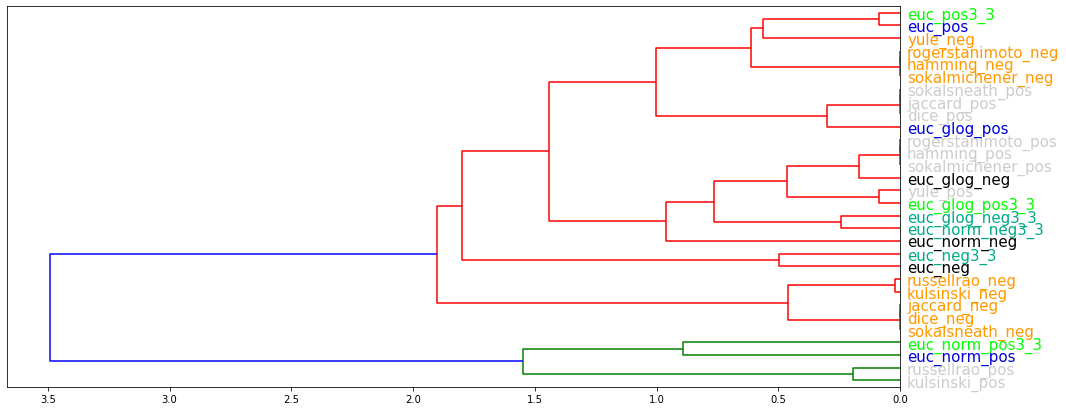

In [90]:
print('Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc - Original peak alignment that all binary measures use (2-1)')
print('Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
Z_S = hier.linkage(df_S, metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_S, labels=df_S.columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc - Original peak alignment that all binary measures use (2-1)
Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


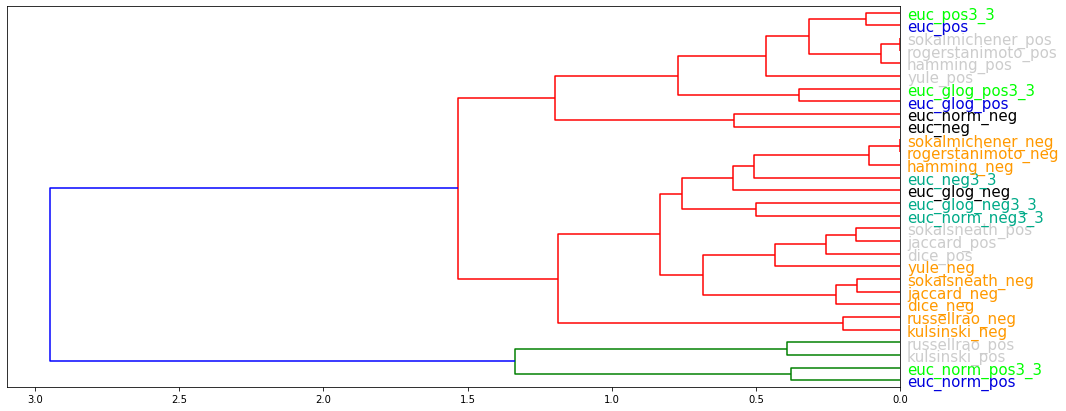

In [91]:
print('Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc - Original peak alignment that all binary measures use (2-1)')
print('Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
Z_C = hier.linkage(df_C, metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_C, labels=df_C.columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

### Distance discrimination of all methods applied (and shown in previous heatmap/dendrogram).

In [92]:
#Preparing Z linkage matrices
Z = []
Z.extend(euclidean)
Z.extend(Z_neg)
Z.extend(Z_pos)

In [93]:
disc_average = np.zeros((1,30))
disc_median = np.zeros((1,30))
disc_correct = np.zeros((1,30))
for i in range(len(Z)):
    discrim = sca.dist_discrim(aligned_all_neg, Z[i], 3, method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = sca.dist_discrim(aligned_all_neg, Z[i], 3, 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames)

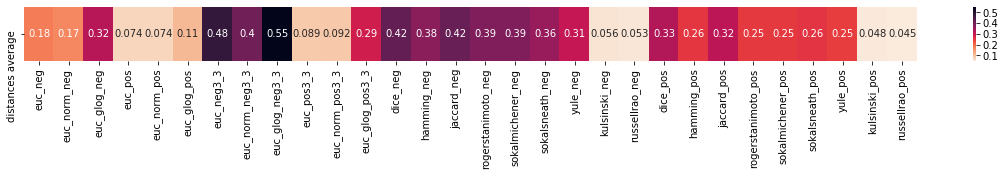

In [94]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)

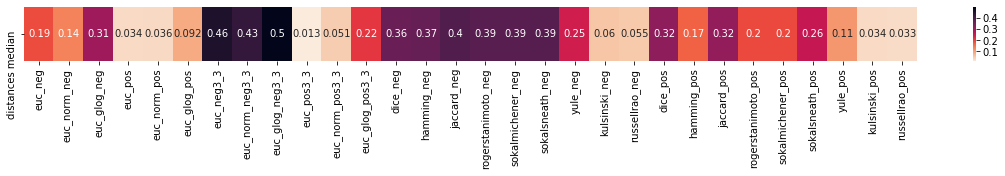

In [95]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

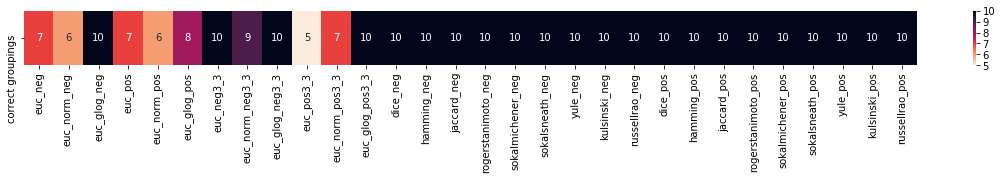

In [96]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### K-means clustering

In [97]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering and how samples are separated 
Use of the module do sci-kit learn - sklearn. Cluster number equal to the amount of varieties. How well can this method separate the varieties. Default parameters except number of clusters.

This example doesn't necessarily mirror the results below (for the case in example) since K-means clustering has an intrinsically random side to it and the clustering is performed again for the case example.

In [98]:
Kmean = skclust.KMeans(n_clusters=10)

In [99]:
a = Kmean.fit(Euc_glog_neg.data.T)

In [100]:
dicto = {}
for i in range(len(a.labels_)):
    if a.labels_[i] in dicto:
        dicto[a.labels_[i]].append(aligned_all_neg.labels[i])
    else:
        dicto[a.labels_[i]] = [aligned_all_neg.labels[i]]
dicto

{9: ['CAN', 'CAN', 'CAN'],
 3: ['CS', 'CS', 'CS'],
 1: ['LAB', 'LAB', 'LAB'],
 5: ['PN', 'PN', 'PN'],
 4: ['REG', 'REG', 'REG'],
 8: ['RIP', 'RIP', 'RIP'],
 7: ['RL', 'RL', 'RL'],
 2: ['ROT', 'ROT', 'ROT'],
 0: ['RU', 'RU', 'RU'],
 6: ['TRI', 'TRI', 'TRI']}

### K-means clustering applied to all euclidean methods and the binary matrixes built

To try and get a condensed and more easily digestible version of the results, a method similar to the discrimination distance performed in the hierarchical clustering was made. The same metrics as before are used

Replicates of a variety can be together in a cluster but, if there are more samples in the same cluster, its "discrimination distance" is still zero. Therefore, this method is harsher than the original dist_discrim method.

In [101]:
def Kmeans_discrim(Spectra, sample_number, method = 'average'):
    Kmean2 = skclust.KMeans(n_clusters = len(Spectra.unique_labels()))
    Kmean = Kmean2.fit(Spectra.data.T)
    Clusters = {}
    Correct_Groupings = dict(zip(Spectra.unique_labels(), [
                      0] * len(Spectra.unique_labels())))
    distc = dist.pdist(Kmean.cluster_centers_)
    distma = dist.squareform(distc)
    maxi = max(distc)
    for i in range(0,len(Spectra.labels), sample_number):
        Clusters[Spectra.labels[i]] = Kmean.labels_[i:i+sample_number]
        if (Kmean.labels_ == Kmean.labels_[i]).sum() == sample_number:
            Correct_Groupings[Spectra.labels[i]] = min(distma[Kmean.labels_[i],:][distma[Kmean.labels_[i],:]!=0])/maxi
            
    if method == 'average':
        Correct_Groupings_M = np.array(list(Correct_Groupings.values())).mean()
    elif method == 'median':
        Correct_Groupings_M = np.median(list(Correct_Groupings.values()))
        if Correct_Groupings_M == 0:
            Correct_Groupings_M = None
    else:
        raise ValueError(
            'Method not recognized. Available methods: "average", "median".')
        
    return Correct_Groupings_M, Correct_Groupings

In [102]:
aligned_neg2 = df_to_bool(aligned_all_neg2.data)
aligned_pos2 = df_to_bool(aligned_all_pos2.data)

In [103]:
colnames2 = ['euc_neg', 'euc_norm_neg', 'euc_glog_neg', 'euc_pos', 'euc_norm_pos', 'euc_glog_pos','euc_neg3_3', 'euc_norm_neg3_3', 
            'euc_glog_neg3_3', 'euc_pos3_3', 'euc_norm_pos3_3', 'euc_glog_pos3_3','aligned_neg', 'aligned_pos','aligned_neg3_3', 
             'aligned_pos3_3']

In [104]:
euclidean = (Euc_neg, Euc_norm_neg, Euc_glog_neg, Euc_pos, Euc_norm_pos, Euc_glog_pos,
            Euc_neg2, Euc_norm_neg2, Euc_glog_neg2, Euc_pos2, Euc_norm_pos2, Euc_glog_pos2)#, 
binaries = (aligned_neg, aligned_pos, aligned_neg2, aligned_pos2)

In [105]:
from metabolinks import AlignedSpectra

In [106]:
disc_average = np.zeros((1,16))
disc_median = np.zeros((1,16))
disc_correct = np.zeros((1,16))
for i in range(len(euclidean)):
    discrim = Kmeans_discrim(euclidean[i], 3, method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = Kmeans_discrim(euclidean[i], 3, method = 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])
for i in range(len(binaries)):
    discrim = Kmeans_discrim(AlignedSpectra(binaries[i], labels = aligned_all_neg.labels), 3, method = 'average')
    disc_average[0,12 + i] 
    disc_average[0,12 + i] = discrim[0]
    disc_median[0,12 + i] = Kmeans_discrim(AlignedSpectra(binaries[i], labels = aligned_all_neg.labels), 3, method = 'median')[0] 
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,12 + i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames2)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames2)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames2)

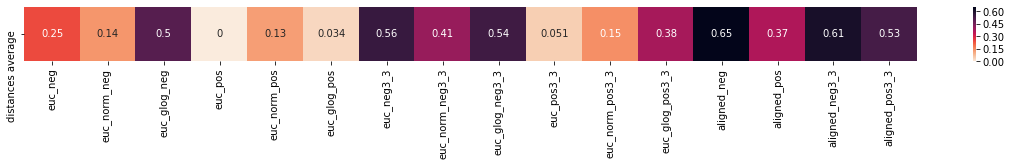

In [107]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)

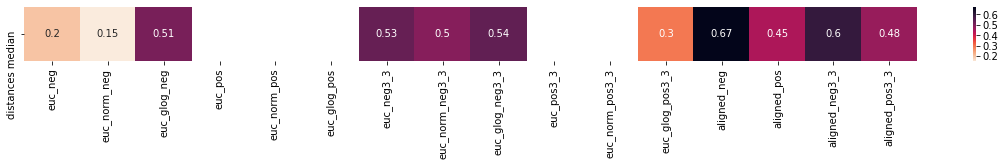

In [108]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

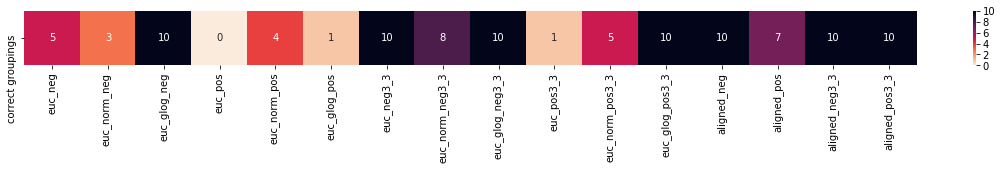

In [109]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### Results summary of dendrograms made with the heatmaps

- See original similarity_analysis. (The discussion of the other peak_alignments aren't written in-depth).